# DTSA 5509 Machine Learning - Supervised
## Final Project

### Introduction:

The purpose of this project is to create a supervised machine learning model which can predict the approval status of a loan application at a lending institution. 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  ConfusionMatrixDisplay, classification_report, accuracy_score

import projectfunctions as cf

from sklearn.feature_selection import SelectKBest, chi2, RFECV

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# load data
data = pd.read_csv('loan_approval_dataset.csv')

# view first few lines
data.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


### Exploratory Data Analysis:

In [3]:
data.describe(include = 'all')

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4269.000000,4269.000000,4269,4269,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269
unique,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,Graduate,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Approved
freq,NaN,NaN,2144,2150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2656
mean,2135.000000,2.498712,NaN,NaN,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,NaN
std,1232.498479,1.695910,NaN,NaN,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,NaN
min,1.000000,0.000000,NaN,NaN,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,NaN
25%,1068.000000,1.000000,NaN,NaN,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,NaN
50%,2135.000000,3.000000,NaN,NaN,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,NaN
75%,3202.000000,4.000000,NaN,NaN,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


#### Some observations about the data:
* no columns are missing data
* loan_id will be dropped, as there's no need for 2 indices
* looking at the column of column names, there appears to be a leading space in some of the column names. These will need to be stripped out during cleaning.
* columns 4:11 (income_annum:bank_asset_value) are numerical and will need to be scaled in preprocessing.
* no_of_dependents is a numerical column, but will need to be converted to categorical.


Now to have a look at the object columns and the unique values of their contents:

In [5]:
obj_cols = data.select_dtypes(include = 'object').columns

for column in obj_cols:
    unique_values = data[column].unique()
    print(f'''Unique values in column '{column}': {unique_values}''')

Unique values in column ' education': [' Graduate' ' Not Graduate']
Unique values in column ' self_employed': [' No' ' Yes']
Unique values in column ' loan_status': [' Approved' ' Rejected']


#### Some observations about the data:
* I can see there are leading spaces in the string values. These will have to be stripped out during cleaning.
* There are only 2 values each for education and self-employed. I'll convert these columns to binary.
* Loan status is the target column with only 2 values, meaning this is a <u>binary classification problem </u>.

### Data Cleaning:

* I created a custom function to strip the leading spaces out of the column names and out of the object columns.
* The data was quite clean to begin with, so nothing else was required.
* If there were any missing values that needed to be imputed, they would be dealt with by the column transformer within my pipeline (see section below on data transformers).

In [6]:
# remove spaces
data = cf.strip_spaces(data)

### Time to split the data into training and testing sets, and separate the data into X and y variables

In [7]:
# split data
train_df, test_df = train_test_split(data, test_size = 0.20, random_state = 2024)

In [8]:
# separate X and y variables
X_train = train_df.drop(columns = 'loan_status')
y_train = train_df['loan_status']
X_test = test_df.drop(columns = 'loan_status')
y_test = test_df['loan_status']

#### Loan status is the target
Lets take a look at how the data is distributed:

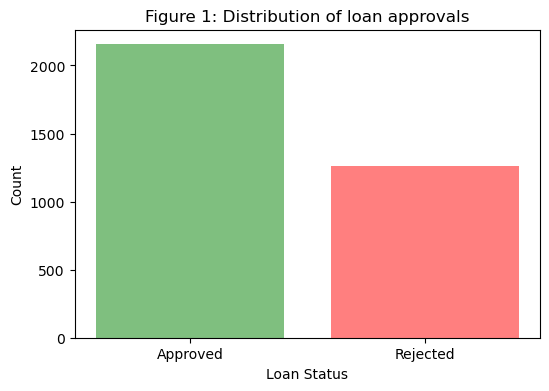

In [9]:
sorted_aprov_counts = train_df['loan_status'].value_counts().sort_values(ascending=False)

colors = ['green' if loan_status == 'Approved' else 'red' for loan_status in sorted_aprov_counts.index]

plt.figure(figsize=(6, 4))
plt.bar(sorted_aprov_counts.index, sorted_aprov_counts.values, color=colors, alpha=0.5)
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Figure 1: Distribution of loan approvals')
plt.show()

# fELICIA: HOW WILL YOU DEAL WITH THIS CLASS IMBALANCE?

Here we have a class imbalance. Imbalanced target data could cause the model to be biased towards the larger proportion of data, in this case, it is Approved status. Some strategies to address this class imbalance are ensembling methods such as AdaBoost, gradient boosting, or balanced random forest classifier.

Other methods may be Changing Performance Metrics:

Instead of accuracy, use metrics like precision, recall, F1-score, or ROC-AUC that are more informative for imbalanced datasets.

### Distribution of the categorical variables

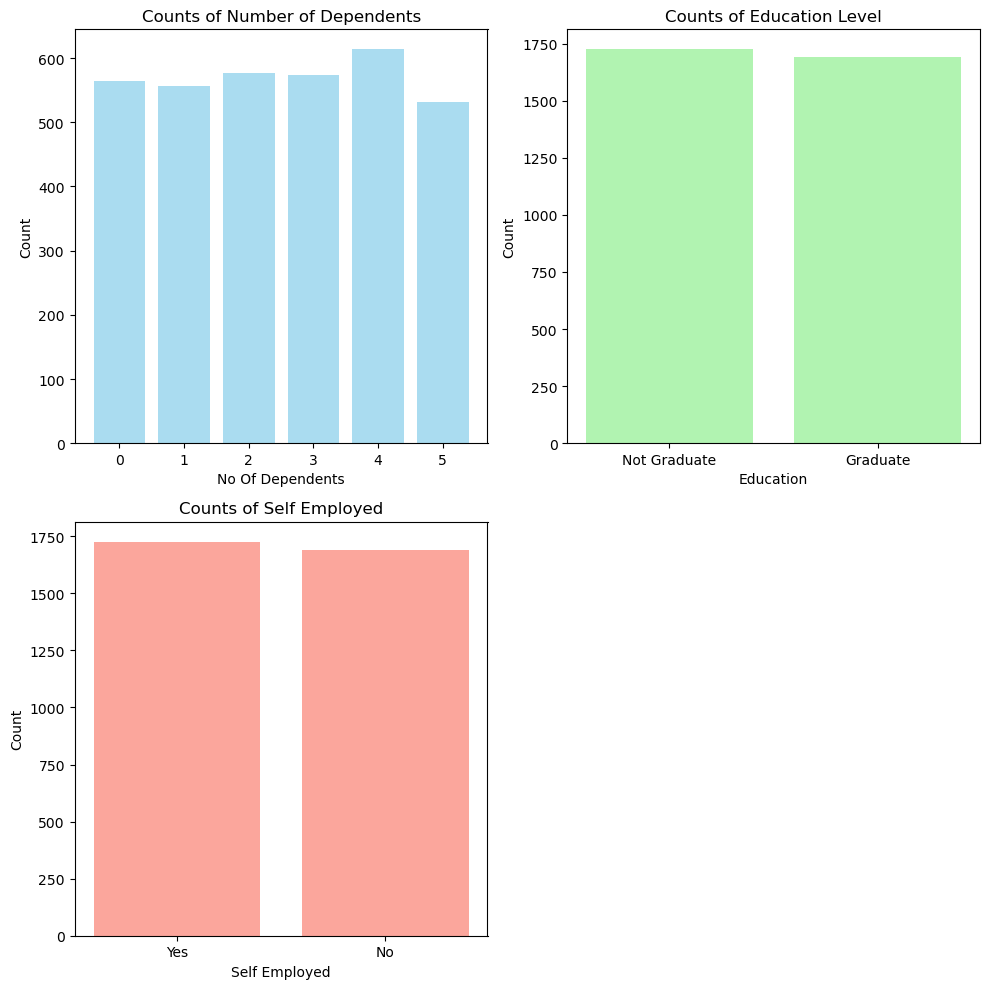

In [10]:


# Columns to plot
columns = ['no_of_dependents', 'education', 'self_employed']
colors = ['skyblue', 'lightgreen', 'salmon']
titles = ['Counts of Number of Dependents', 'Counts of Education Level', 'Counts of Self Employed']

# Create a figure and axis objects with a 3 x 1 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs = axs.flatten()

# Loop through columns and plot
for i, col in enumerate(columns):
    counts = train_df[col].value_counts()
    axs[i].bar(counts.index, counts.values, color=colors[i], alpha=0.7)
    axs[i].set_xlabel(col.replace('_', ' ').title())
    axs[i].set_ylabel('Count')
    axs[i].set_title(titles[i])
    
axs[3].axis('off') 

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


Upon viewing the distribution of the categorical columns, I can see that they are all relatively balanced. I suspect that they don't carry much explanatory power, and their use will be determined based on their importance during the feature selection process. 

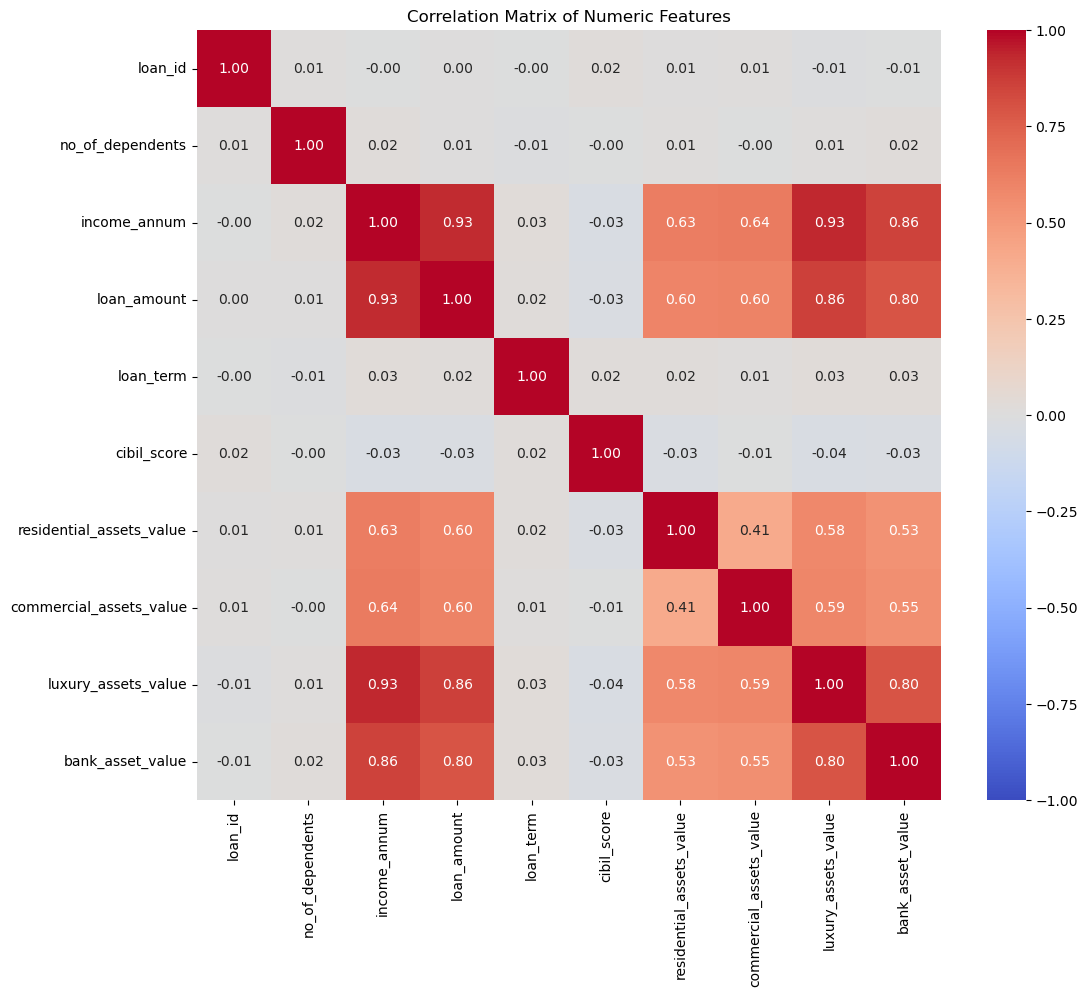

In [11]:
# select only num columns
numeric_features = train_df.select_dtypes(include=[np.number])

# correlation matrix
corr = numeric_features.corr()

# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

This heatmap shows that some of the numeric features are highly correlated with each other. While this is a classification problem and not a linear regression problem, multicollinearity is still an issue. These features will also be assessed in the feature selection process.

## Modelling:

For the first iteration of modeling, I'll use all the features (except for loan_id) just for funsies to see what happens.

In [12]:
# categorize the feats round 1

drop_feats = ['loan_id']

categorical_feats = ['education', 'self_employed',
              'no_of_dependents']

numeric_feats = ['income_annum', 'loan_term', 'cibil_score', 'loan_amount', 
              'luxury_assets_value',
              'bank_asset_value', 'residential_assets_value', 
                 'commercial_assets_value']

binary_feats = []

#### Data transformers:

The code cell below specifies how each type of features will be treated. Because I like to handle the data as little as possible before doing a train_test_split, I need a way to consistently process both the training and testing data after a split: SkLearn's Pipeline and Preprocessing modules are extremely convenient for this. While there are no missing values within my dataset, imputing missing values has been left in so that this framework may be again used on a broader range of datasets.

In [13]:
# specify transformers - all rounds

categorical_transformer = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                                       OneHotEncoder(dtype = int, 
                                                     handle_unknown = 'ignore'))
                                        
numeric_transformer = make_pipeline(SimpleImputer(strategy = 'median'),
                                   (StandardScaler()))
 
                                  
binary_transformer = make_pipeline(SimpleImputer(strategy = 'most_frequent'), 
                                                 OneHotEncoder(drop = 'if_binary',
                                                 dtype = int,
                                                 sparse_output = False))


#### Preprocessor:

In [14]:
# create pre-processor

preprocessor = make_column_transformer((categorical_transformer, categorical_feats),
        (numeric_transformer, numeric_feats),
        (binary_transformer, binary_feats),
        ('drop', drop_feats),                              
        remainder='passthrough')

### Modelling - Round 1

In [15]:
models = { 
    'Dummy Classifier': DummyClassifier(strategy = 'most_frequent'),
    'RBF SVM': SVC(random_state = 2024),
    'kNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state = 2024)    
        
        }

results1 = []

for model_name, model in models.items():

    # pipeline
    model_selection_pipe = make_pipeline(preprocessor, model)
    
    # cross validation
    scores = cross_validate(model_selection_pipe, X_train, y_train, cv=5, return_train_score=True)

    # collect results
    model_results = {
        'model': model_name,
        'mean_train_accuracy': round(scores["train_score"].mean(), 4),
        'mean_validation_accuracy': round(scores["test_score"].mean(), 4),
        'mean_fit_time (s)': round(scores["fit_time"].mean(), 4),
        'mean_score_time (s)': round(scores["score_time"].mean(), 4)
    }
    
    results1.append(model_results)

results_df1 = pd.DataFrame(results1)
#results_df.to_csv('train_reduced_features_2.csv', index = False)
results_df1

,model,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s)
0,Dummy Classifier,0.6310,0.6310,0.0108,0.0042
1,RBF SVM,0.9595,0.9447,0.0781,0.0365
2,kNN,0.9329,0.8899,0.0131,0.0356
3,Random Forest,1.0000,0.9751,0.2296,0.0107


#### Round 1 results:

Not bad over-all, then again, it's a pretty simple model to begin with. 

### Feature Selection - Categorical
Now lets evaluate the categorical features and see how much we can reduce noise in the data and improve performance. As noted during the EDA process, I suspected that these features wouldn't be very important as there wasn't much difference between the values within each feature.

To more formally assess the features, I will use the Chi-Squared test (a high chi-squared value could be considered upwards of 10 to 20) and p-values (at a significance level of $\alpha = 0.05$) to determine how significant they are.


In [16]:
# from above...
categorical_feats = ['education', 'self_employed', 'no_of_dependents']

# label encode the cat feats
label_encoders = {}
X_train_encoded = X_train.copy()

for col in categorical_feats:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col])
    label_encoders[col] = le

# chi-sqr test
chi2_scores, p_values = chi2(X_train_encoded[categorical_feats], y_train)

# result to df
chi2_df = pd.DataFrame({
    'feature': categorical_feats,
    'chi-sqr score': chi2_scores,
    'p-value': p_values
})


chi2_df

,feature,chi-sqr score,p-value
0,education,0.209441,0.647206
1,self_employed,0.019571,0.888741
2,no_of_dependents,0.386087,0.534363


#### Evaluation of categorical features:

In the above cell I calculated the chi-squared and p-values of each of the categorical features to determine their statistical significance. The chi-squared score measures the strength of association between each feature and the target variable, and a high chi-squared score indicates a stronger relationship. The p-values will indicate the probability that the observed association is by chance, and a low p-value would indicate that the feature is statistically significant in its association with the target feature.

In the results above, the categorical features 'education', 'self_employed', and 'no_of_dependents' all have very low chi-squared values of less than 1, indicating that none of them are strongly associated with the target 'loan_status'. The p-values for the categorical features are all much higher than the pre-specified $\alpha = 0.05$, which indicates that the observed associations with the target are not statistically significant.

As determined by these results, all three of 'education', 'self_employed', and 'no_of_dependents' will be added to the drop_features list

### Modelling - Round 2

Now that some features will be removed, I'd like to do another round of modelling to see how the model performs.

In [17]:
# add dropped feats
drop_feats = ['loan_id', 'education', 'self_employed', 'no_of_dependents']
categorical_feats = []

results2 = []

# re-define preprocessor

preprocessor = make_column_transformer((categorical_transformer, categorical_feats),
        (numeric_transformer, numeric_feats),
        (binary_transformer, binary_feats),
        ('drop', drop_feats),                              
        remainder='passthrough')
 
for model_name, model in models.items():

    # pipeline
    model_selection_pipe = make_pipeline(preprocessor, model)
    
    # cross validation
    scores = cross_validate(model_selection_pipe, X_train, y_train, cv=5, return_train_score=True)

    # collect results
    model_results = {
        'model': model_name,
        'mean_train_accuracy': round(scores["train_score"].mean(), 4),
        'mean_validation_accuracy': round(scores["test_score"].mean(), 4),
        'mean_fit_time (s)': round(scores["fit_time"].mean(), 4),
        'mean_score_time (s)': round(scores["score_time"].mean(), 4)
    }
    
    results2.append(model_results)
results_df2 = pd.DataFrame(results2)



In [18]:
# view round 2 results
results_df2

,model,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s)
0,Dummy Classifier,0.6310,0.6310,0.0058,0.0026
1,RBF SVM,0.9566,0.9441,0.0558,0.0287
2,kNN,0.9546,0.9236,0.0083,0.0298
3,Random Forest,1.0000,0.9813,0.2026,0.0074


In [19]:
results_df1 = results_df1.set_index('model')
results_df2 = results_df2.set_index('model')


In [20]:
compare1_2 = results_df2 - results_df1

compare1_2

,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s)
model,,,,
Dummy Classifier,0.0000,0.0000,-0.0050,-0.0016
RBF SVM,-0.0029,-0.0006,-0.0223,-0.0078
kNN,0.0217,0.0337,-0.0048,-0.0058
Random Forest,0.0000,0.0062,-0.0270,-0.0033


#### Comparing first and second round training and validation results

There was a very small decrease in the mean training and validation accuracies under the RBF SVM model after the education, number of dependents, and employment features were removed.

There was a small increase in the mean training and validation accuracies under the kNN model, and a very small increase in the mean validation accuracy under the random forest model.

### Feature Selection - Numerical

Now I'll evaluate the numerical features. As noted upon creating the correlation matrix earlier, there was some strong collinearity between the numerical features. To formally assess the multicollinearity, I will calculate the Variance Inflation Factors, or VIF (a high VIF to indicate multicollinearity could be considered to be around 5 to 10).

In [21]:
# df for results
vif_data = pd.DataFrame()
vif_data['feature'] = X_train[numeric_feats].columns

# vif for each feat
vif_data['VIF'] = [variance_inflation_factor(X_train[numeric_feats].values, i) for i in range(len(X_train[numeric_feats].columns))]

vif_data.sort_values(by = 'VIF', ascending = False)

,feature,VIF
0,income_annum,73.980969
4,luxury_assets_value,27.493059
3,loan_amount,27.463015
5,bank_asset_value,12.444291
2,cibil_score,5.063267
1,loan_term,3.924715
6,residential_assets_value,3.845542
7,commercial_assets_value,3.844393


#### Evaluation of numerical features:

In the results above, the worst offenders for multicollinearity are 'income_annum', 'luxury_assets_value', 'loan_amount', and 'bank_asset_value'. Intuitively this makes sense because a borrower with a higher income is likely to also have more luxury, banking assets, and afford more loans than a borrower with a lower income. 

The features 'loan_term', 'residential_assets_value' and 'commercial_assets_value' have low VIF below the pre-specified factor of 5 through 10. 'cibil_score' is on the edge of indicating collinearity. I will remove some of the worst offenders and see how that effects the VIF of 'cibil_score'.

I suspect, from personal experience, that income_annum would be highly important in determining a borrower's loan approval status. If I knew anyone in the banking industry, I could consult their industry expertise to determine which factors would be the most important in a model. For now, I will go with my intuition and remove 'luxury_assets_value' and 'bank_asset_value' and reassess the VIFs.

In [22]:
numeric_feats = ['income_annum', 'loan_term', 
                 'cibil_score', 'loan_amount', 
                 'residential_assets_value', 
                 'commercial_assets_value']

# df for results
vif_data2 = pd.DataFrame()
vif_data2['feature'] = X_train[numeric_feats].columns

# vif for each feat
vif_data2['VIF'] = [variance_inflation_factor(X_train[numeric_feats].values, i) for i in range(len(X_train[numeric_feats].columns))]

vif_data2.sort_values(by = 'VIF', ascending = False)

,feature,VIF
0,income_annum,34.242230
3,loan_amount,27.461309
2,cibil_score,5.058730
1,loan_term,3.924005
5,commercial_assets_value,3.843643
4,residential_assets_value,3.841435


After dropping the luxury and commercial asset features, the VIF for income dropped significantly. I'll drop 'loan_amount' next and reassess the VIFs.

In [23]:
numeric_feats = ['income_annum', 'loan_term', 'cibil_score', 
                 'residential_assets_value', 'commercial_assets_value']

# df for results
vif_data3 = pd.DataFrame()
vif_data3['feature'] = X_train[numeric_feats].columns

# vif for each feat
vif_data3['VIF'] = [variance_inflation_factor(X_train[numeric_feats].values, i) for i in range(len(X_train[numeric_feats].columns))]

vif_data3.sort_values(by = 'VIF', ascending = False)

,feature,VIF
0,income_annum,9.034713
2,cibil_score,5.058586
1,loan_term,3.923893
4,commercial_assets_value,3.838758
3,residential_assets_value,3.836360


... and now I'm curious to see what happens when loan amount is included and income is removed...

In [24]:
numeric_feats = ['loan_term', 'cibil_score', 'loan_amount',
                 'residential_assets_value', 'commercial_assets_value']

# df for results
vif_data4 = pd.DataFrame()
vif_data4['feature'] = X_train[numeric_feats].columns

# vif for each feat
vif_data4['VIF'] = [variance_inflation_factor(X_train[numeric_feats].values, i) for i in range(len(X_train[numeric_feats].columns))]

vif_data4.sort_values(by = 'VIF', ascending = False)

,feature,VIF
2,loan_amount,7.245586
1,cibil_score,4.933899
0,loan_term,3.897823
3,residential_assets_value,3.601614
4,commercial_assets_value,3.598940


Upon dropping income and including loan amount, the VIFs dropped significantly. While the loan amount is sort of in the middle of the pre-specified 'high VIF' range, it's still below the value of 10, so I'll keep it.

In [25]:
# redefine features
drop_feats = ['loan_id', 'education', 'self_employed',
              'no_of_dependents', 'income_annum', 'luxury_assets_value', 'bank_asset_value']

categorical_feats = []

numeric_feats = ['loan_term', 'cibil_score', 'loan_amount', 
                 'residential_assets_value', 'commercial_assets_value']

binary_feats = []

results3 = []

# redefine preprocessor
preprocessor = make_column_transformer((categorical_transformer, categorical_feats),
        (numeric_transformer, numeric_feats),
        (binary_transformer, binary_feats),
        ('drop', drop_feats),                              
        remainder='passthrough')

models = { 
    'Dummy Classifier': DummyClassifier(strategy = 'most_frequent'),
    'RBF SVM': SVC(random_state = 2024),
    'kNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state = 2024)    
        
        }


for model_name, model in models.items():

    # pipeline
    model_selection_pipe = make_pipeline(preprocessor, model)
    
    # cross validation
    scores = cross_validate(model_selection_pipe, X_train, y_train, cv=5, return_train_score=True)

    # collect results
    model_results = {
        'model': model_name,
        'mean_train_accuracy': round(scores["train_score"].mean(), 4),
        'mean_validation_accuracy': round(scores["test_score"].mean(), 4),
        'mean_fit_time (s)': round(scores["fit_time"].mean(), 4),
        'mean_score_time (s)': round(scores["score_time"].mean(), 4)
    }
    
    results3.append(model_results)

results_df3 = pd.DataFrame(results3)

results_df3

,model,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s)
0,Dummy Classifier,0.6310,0.6310,0.0065,0.0030
1,RBF SVM,0.9526,0.9452,0.0537,0.0261
2,kNN,0.9570,0.9247,0.0072,0.0262
3,Random Forest,1.0000,0.9652,0.1871,0.0083


In [26]:
results_df3 = results_df3.set_index('model')

compare2_3 = results_df3 - results_df2

compare2_3

,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s)
model,,,,
Dummy Classifier,0.0000,0.0000,0.0007,0.0004
RBF SVM,-0.0040,0.0011,-0.0021,-0.0026
kNN,0.0024,0.0011,-0.0011,-0.0036
Random Forest,0.0000,-0.0161,-0.0155,0.0009


#### Comparing second and third round training and validation results

There was a very small decrease in the mean training accuracy and very small increase under the RBF SVM model after the income, luxury and bank asset features were removed.

There was a very small increase in the mean training and validation accuracies under the kNN model, and a very small decrease in the mean validation accuracy under the random forest model.

### Model Selection

Random forest has the best training and validation accuracy. 


## Discussion

#### Further Improvements
* statistical testing using paired t-test to determine whether the changed in the mean training and validation accuracy are statistically significant from zero.
* the data and the model are quite simple and used for demonstration purposes only, not to be used in production for approving loans.
* Ethical considerations: the global community has a diverse range of cultures. In some countries it may be completely legal to consider a borrowers gender or family status as part of the loan approval process, while in other countries it may not be. People within any particular culture are also highly diverse amoungst themselves. Having a loan approved could be the deciding factor in whether a borrower can get stable housing and climb their way out of poverty, or afford transportation to be able to access a wider job pool, or gain an education and make changes that affect not just themselves but their local community and beyond. I'd like this small project to be yet another reminder of the impact that machine learning models could have on people who were not represented within the training data if they don't fit the mold. 

### References

* The code structure for my preprocessor and pipeline comes from a course I had previous taken at the University of British Columbia, Extended Learning: FS031 Intro to Machine Learning. 
* Not going to lie, I used OpenAI to assist me with this project - mainly for the plotting and debugging. Nothing was copied and pasted blindly, and I use it as a learning tool (it also steered my wrong a few times lol).